In [2]:
from constants import *
from functions import *
import numpy as np
from scipy.integrate import solve_ivp
import math
from units import *
from scipy.optimize import root_scalar
from numba import njit
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator

In [21]:
plt.rcParams['font.size']=22
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.minor.size']=5
plt.rcParams['xtick.major.width']=2
plt.rcParams['xtick.minor.width']=1
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.minor.size']=5
plt.rcParams['ytick.major.width']=2
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.direction']='in'

In [ ]:
X = 0.75
mu = 0.61
# Mhalo = 1.e10* Msun
# Mdot  = 0.1 * Msun/yr_to_sec/25.

Mhalo = 1.e12* Msun
Ms_Mh = 0.02
lambda_cool = 0.6e-22
Ms_Mh = 0.02

In [3]:
filename = "CloudyData_UVB=HM2012.h5"
Z = 0.3
with h5py.File(filename, "r") as f:
    cloudy_table = f["CoolingRates/Metals/Cooling"][:,0,:]
    mmw = f["CoolingRates/Primordial/MMW"][:,0,:]

cloudy_table *= Z
log10nH_arr = np.linspace(-10.,4, cloudy_table.shape[0])
log10temp_arr = np.linspace(1.,9, cloudy_table.shape[1])

log10lambda_cloudy = interpolate.RegularGridInterpolator(
    (log10nH_arr, log10temp_arr),
    np.log10(cloudy_table),
    bounds_error=False,
    fill_value=None
)

mmw_cloudy = interpolate.RegularGridInterpolator(
    (log10nH_arr, log10temp_arr),
    mmw,
    bounds_error=False,
    fill_value=None
)


In [4]:
rho_arr = 10.**log10nH_arr
temp_arr =10**log10temp_arr
lnT   = np.log(temp_arr)
lnrho = np.log(rho_arr)
lnLambda = np.log(cloudy_table)

In [5]:
dlnLambda_dlnrho, dlnLambda_dlnT = np.gradient(
    lnLambda,
    lnrho,
    lnT,
    edge_order=2
)

interp_dlnLambda_dlnrho = RegularGridInterpolator(
    (lnrho, lnT),
    dlnLambda_dlnrho,
    bounds_error=False,
    fill_value=None
)

interp_dlnLambda_dlnT = RegularGridInterpolator(
    (lnrho, lnT),
    dlnLambda_dlnT,
    bounds_error=False,
    fill_value=None
)

In [6]:
X = 0.75
mu = 0.61
# Mhalo = 1.e10* Msun
# Mdot  = 0.1 * Msun/yr_to_sec/25.

Mhalo = 1.e12* Msun
Ms_Mh = 0.02
lambda_cool = 0.6e-22
Ms_Mh = 0.02

In [7]:
r_grid = np.logspace(np.log10(0.001*kpc), np.log10(25*Rvir(Mhalo)), 1000)
vc_grid = np.zeros(r_grid.shape[0])
i = 0
for r in r_grid:
    vc_grid[i] = v_c(r, Mhalo, Ms_Mh)       
    i+=1
vc_interp = interp1d(r_grid,vc_grid)


In [8]:
lnvc_grid = np.log(vc_grid)
lnr_grid  = np.log(r_grid)

dlnvc_dlnr_grid = np.gradient(lnvc_grid, lnr_grid)
dlnvc_dlnr_grid_interp =  interp1d(r_grid,dlnvc_dlnr_grid)


In [9]:
def soln_at_esp(v_rsonic, T_rsonic, rho_rsonic, rsonic, eps):
    
    dlnvc_dlnr_at_Rsonic = dlnvc_dlnr_grid_interp(rsonic)
    
    vc_rsonic  = vc_interp(rsonic)
    
    cs_rsonic  = v_rsonic
    x = (vc_rsonic/cs_rsonic)**2/2.
    a = 1.0
    
    lnrho = np.log(rho_rsonic)
    lnT = np.log(T_rsonic)
                 
    constant1 = interp_dlnLambda_dlnT((lnrho, lnT)) + 1.5 *  interp_dlnLambda_dlnrho((lnrho, lnT))
    # constant1 = 0.0
    b = 29.0* x/6 - 17.0/6.0 + ((1.-x)/3.) * constant1
    
    constant2 = interp_dlnLambda_dlnrho((lnrho, lnT))
    # constant2 = 0.0
    c = ((2./3.) * x * dlnvc_dlnr_at_Rsonic) +  (5*x*x) - (13.*x/3.0) + (2./3.)  - (5.*(1-x)**2/3.)*constant2
    
    sol1 = (-b - np.sqrt(b*b - 4*a*c))/(2.*a*c)
    sol2 = (-b + np.sqrt(b*b - 4*a*c))/(2.*a*c)
    sol = np.asarray([sol1,sol2])
    dlnv_dlnr_at_Rsonic = -1.5* sol + 3 - 5*x
    dlnM_dlnr = dlnv_dlnr_at_Rsonic - 0.5 * sol
    if(dlnM_dlnr[0]<0.0):   
        dlnT_dlnr_at_Rsonic = sol1
    elif(dlnM_dlnr[1]<0.0):
        dlnT_dlnr_at_Rsonic = sol2
    
    dlnv_dlnr_at_Rsonic = -1.5* dlnT_dlnr_at_Rsonic + 3 - 5*x
    
    delT = 1. + dlnT_dlnr_at_Rsonic * eps
    delv = 1. + dlnv_dlnr_at_Rsonic * eps
    delrho = 1. - (dlnv_dlnr_at_Rsonic + 2.) * eps
    
    T_ini = delT * T_rsonic
    v_ini = delv * v_rsonic
    rho_ini = delrho * rho_rsonic
    r_ini = (1.0 + eps) * rsonic

    return r_ini, v_ini, T_ini, rho_ini
    

In [10]:
def find_init_at_Rsonic(rsonic,T):
    cs = np.sqrt(gamma * kb * T/mu/mp)
    v  = cs
    vc = vc_interp(rsonic)
    tflow = rsonic/v
    
    alpha = mu * (gamma-1) * lambda_cool * tflow/gamma/kb/T
    nH = (2. - (vc/v)**2 )/alpha
    rho = nH * mp/X
    Mdot = 4. * math.pi * rho*rsonic**2 * v

    return v, rho, Mdot

In [11]:

def flow_equations_lnr(lnr, ini_val, Mdot):
    
    logv, logT, logrho = ini_val
    v = np.exp(logv)
    T = np.exp(logT)
    
    rho = np.exp(logrho)
    
    r   = np.exp(lnr)
    nH = X * rho/mp
    mmw_val = mmw_cloudy((np.log10(nH),np.log10(T)))

    cs = np.sqrt(gamma * kb * T/(0.6 * mp))
    # print('CS=',cs/kmps, v/kmps)
    P  = cs*cs*rho/gamma
    
    lambda_cool = 10.**(log10lambda_cloudy((np.log10(nH), np.log10(T)))) 
    # lambda_cool = 0.6e-22
    
    tcool = P/((gamma-1) * nH * nH *  lambda_cool)
    
    
    Mach = np.abs(v)/cs
    tflow = r/np.abs(v)
    tratio = tflow/tcool
    vc_over_cs = vc_interp(r)/cs
    # print(tflow/tcool)
    
    
    numer = 2. - vc_over_cs**2 - tratio/gamma
    denom = Mach * Mach - 1.0

    dlnv_dlnr   = numer/denom
    dlnrho_dlnr = -2. - dlnv_dlnr 
    dlnT_dlnr   = (gamma - 1.) * dlnrho_dlnr + tratio
    
    return dlnv_dlnr, dlnT_dlnr, dlnrho_dlnr

In [39]:
def find_supersonic_sol(v_rsonic, T_rsonic, rho_rsonic, Mdot, rsonic):
    
    eps = 1.e-5

    rmax  =  rsonic*(1.+eps)
    rmin  =  1.e-3*kpc
    
    r_ini, v_ini, T_ini, rho_ini = soln_at_esp(v_rsonic, T_rsonic, rho_rsonic, rsonic, eps)
    print(   r_ini/kpc, v_ini/kmps, T_ini/1.e6, rho_ini/mp)
    #Solve equation in beta
    ini_value = [v_ini, T_ini, rho_ini]
    
    log_ini_value = np.log(ini_value)
    lnr_span = (np.log(rmax), np.log(rmin))
    lnr_eval = np.linspace(lnr_span[0], lnr_span[1], 2000)

    sol = solve_ivp(flow_equations_lnr, lnr_span, log_ini_value, t_eval=lnr_eval, method='RK45',args=(Mdot,))
    
    lnv_sol, lnT_sol, lnrho_sol = sol.y
    return lnv_sol, lnT_sol, lnrho_sol, lnr_eval

In [40]:
rsonic = 0.6*kpc
vc = vc_interp(rsonic)
v_rsonic = 138.02501810196222 * kmps
rho_rsonic = 0.06923077901832848 * mp
T_rsonic = 1.0920035497343274 * 1.e6
Mdot = 4. * math.pi * rsonic * rsonic * rho_rsonic * v_rsonic
solution = find_supersonic_sol(v_rsonic, T_rsonic, rho_rsonic, Mdot, rsonic)

0.600006 138.01269602216422 1.0920661741025133 0.06923557492853447


/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_44297/4267089151.py:4: RuntimeWarning: overflow encountered in exp
  v = np.exp(logv)
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_44297/4267089151.py:5: RuntimeWarning: overflow encountered in exp
  T = np.exp(logT)
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_44297/4267089151.py:11: RuntimeWarning: divide by zero encountered in log10
  mmw_val = mmw_cloudy((np.log10(nH),np.log10(T)))
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_44297/4267089151.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  P  = cs*cs*rho/gamma
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_44297/4267089151.py:17: RuntimeWarning: divide by zero encountered in log10
  lambda_cool = 10.**(log10lambda_cloudy((np.log10(nH), np.log10(T))))
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_44297/4267089151.py:23: RuntimeWarning: invalid value encountered in scalar divide
  Mach = 

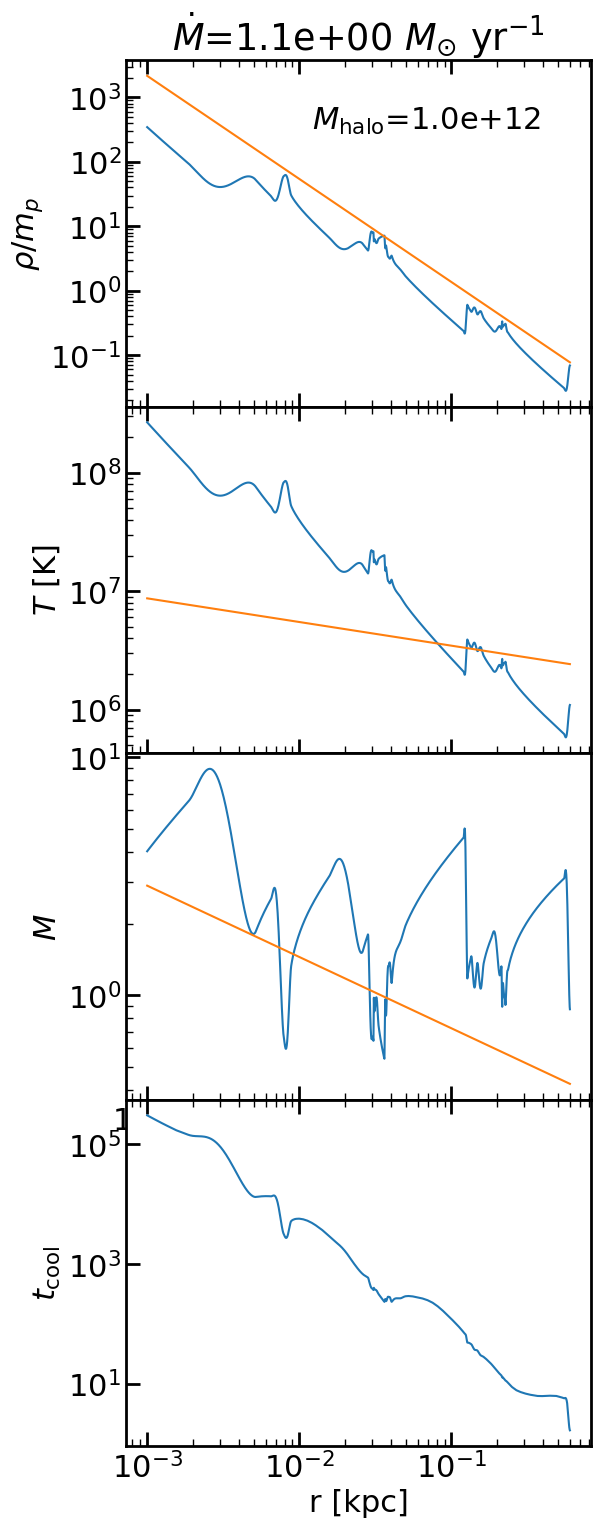

In [41]:
v = np.exp(solution[0])
T = np.exp(solution[1])
rho = np.exp(solution[2])
lnr = (solution[3])
cs = np.sqrt(gamma * kb * T/(0.6 * mp))
Mach = v/cs


rkpc = np.exp(lnr)/kpc
r = rkpc*kpc

tflow = np.exp(lnr)/v
tff = np.sqrt(2) * r/v

tcool = np.zeros(rkpc.shape[0])
for i in range(tcool.shape[0]):
    P = kb * rho[i] * T[i]/mu/mp
    nH = X*rho[i]/mp
    log10nH = np.log10(nH)
    log10T  = np.log10(T[i])
    cloudy = 10.**(log10lambda_cloudy((log10nH, log10T)))
    # cloudy = 0.6e-22
    tcool[i] = P/(nH*nH*cloudy*(gamma-1))

tratio = tcool/tflow

m=-0.1
vc = 140. * (rkpc/(100)) **m * kmps
A = 0.9 * (1.-2*m)
B = 1. + 4.*m/3.
Tvir = T_vir(Mhalo)
Rvir_ = Rvir(Mhalo)
Tranl = mu * mp * vc*vc/gamma/kb

Mach_anl  = X*A/mp/vc**2 * np.sqrt(5*Mdot *lambda_cool/(18.*math.pi*B*r))
nH_anl    = 1.6e-5 * (Mhalo/(1.e12*Msun))**(0.36) * (Mdot/(Msun/yr_to_sec))**0.5 * (lambda_cool/1.e-22)**(-0.5) * (r/100/kpc)**(-1.6)
tcool_anl = 7.2 * (Mhalo/(1.e12*Msun))**(0.36) * (Mdot/(Msun/yr_to_sec))**(-0.5) * (lambda_cool/1.e-22)**(-0.5) * (r/100/kpc)**(1.4)


fig, ax = plt.subplots(4, 1, gridspec_kw = {'wspace':0.1, 'hspace':0.0},figsize=(6, 18)) 

ylabel = [r'$\rho/m_p$', r'$T$ [K]', r'$M$', r'$t_{\rm cool}$']

ax[0].plot(rkpc, rho/mp)
ax[0].plot(rkpc, nH_anl)
ax[1].plot(rkpc, T)
ax[1].plot(rkpc, Tranl)
ax[2].plot(rkpc, Mach)
ax[2].plot(rkpc, Mach_anl)
# ax[3].plot(rkpc, tcool/yr_to_sec/1.e9)
# ax[3].plot(rkpc, tcool_anl)
ax[3].plot(rkpc, tratio)


ax[-1].set_xlabel('r [kpc]')

for i in range(4):
    ax[i].set_ylabel(ylabel[i])
plt.setp(ax, 'xscale', ('log'))
plt.setp(ax, 'yscale', ('log'))
# plt.setp(ax, 'xlim', (0.5,2.e2))
# ax[0].set_ylim(1.e-6, 4.e-1)
# ax[1].set_ylim(1.e5, 4.e7)
# ax[2].set_ylim(1.e-2,1.e1)
# ax[3].set_ylim(1.e-3,1.e2)

ax[0].tick_params(axis='x', which='both', labelbottom=False, top=True, bottom=True)
ax[1].tick_params(axis='x', which='both', labelbottom=False, top=True, bottom=True)
ax[-1].tick_params(axis='x', which='both', top=True, bottom=True, labelbottom=True)
ax[0].set_title(r'$\dot{M}$=%.1e'%(Mdot*yr_to_sec/Msun) + r' $M_{\odot} \ \rm{yr}^{-1}$')
ax[0].text(0.4, 0.8, r'$M_{\rm halo}$=%.1e'%(Mhalo/Msun), transform=ax[0].transAxes)
# ax[0].text(0.6, 0.7, r'$M_{\rm gas}$=%.1e'%(tot_gas_mass/Msun), transform=ax[0].transAxes)
# ax[0].text(0.6, 0.7, r'$\rho_{\rm ini}$=%.1e'%(rho0/mp), transform=ax[0].transAxes)
# ax[0].text(0.6, 0.6, r'$T_{\rm ini}$=%.1e'%(T), transform=ax[0].transAxes)

image_name = 'Figures/solution_' + str(Mdot*yr_to_sec/Msun) +'.jpeg'
# plt.savefig(image_name, bbox_inches='tight')